## Assignment 2, MECH 501
David Brenken 260786037

#### Task 1.  
 The problem, related to mechanical engineering, is: can a CNN classify common household sounds? And how does manipulation (in particular, the short-term fourier transform window function) of the time-series acoustic data affect classification? In the context of mechanical engineering, this is a useful application with respect to robotics and automtion tasks in a domestic environment. For example, if a personal care robot can correcly identify the difference between a dog's bark and a cat's meow, and the owner owned a cat but not a dog, the robot could make different decisions based on the fact that there is a dog in the vicinity.

 A more general example (not studied in the selected dataset) of a useful sound to identify would be the sound of a human falling, which would be invaluable in elder care, as falls can be seriously dangerous. In any case, sound identification provides useful information to a variety of systems related to mechanical engineering.
     
 The application of CNNs to audio identification is not novel, and there is an established pipeline [1]. There is the question of what sounds this pipeline is applied to, as applications like speech are well studied. To incorporate novel elements into this project, I will be focusing specifically on the effect of the window function on the data processing function.


 [1] M. Dörfler, R. Bammer and T. Grill, "Inside the spectrogram: Convolutional Neural Networks in audio processing," 2017 International Conference on Sampling Theory and Applications (SampTA), Tallinn, Estonia, 2017, pp. 152-155, doi: 10.1109/SAMPTA.2017.8024472.

#### Task 2 
 The dataset which is chosen comes from [here](https://project.inria.fr/desed/). It is a dataset of 10 different common household sounds. The sounds are: Alarm/bell/ringing, Blender, Cat, Dog, Dishes, Electric shaver/toothbrush, Frying, Running water, Speech, Vacuum cleaner.

Initially, this project was to use the dataset built for robotics found [here](https://dhiraj100892.github.io/swoosh/). However, this dataset was hosted on dropbox and dropbox auto-disables links which have had many accesses, so I was unable to download this dataset. I sent emails to the authors of the papers, and received no response, so I switched to the most similar dataset I could find.

#### Task 3/ Task 4 
Convolutional neural networks, as discussed in class, are frequently used to analyze time series and frequency domain data. I will be using a CNN to attempt to classify sounds in this dataset.

The general pipeline I will follow is this:

1. **Data Processing**  
    a. Resample Data  
    b. Generate Spectrograms

2. **CNN creation and application**  
    a. Generate a labelled dataset  
    b. Split the dataset into training, validation, and test sets  
    c. Define the CNN architecture

3. **Training the CNN**  
    a. Set up training hyperparameters   
    b. Compile the model   
    c. Train the CNN on the training set          
    d. Validate the model on the validation set  

4. **Evaluation and Tuning**  
    a. Evaluate model performance on a test set  
    b. Analyze and interpret evaluation metrics (in this case Binary cross-entropy loss, binary accuracy, and precision)  
    c. Tune the model based on evaluation results  

6. **Window function evaluation**  
    a. Use the tuned CNN, with different window functions, and compare the results     


NOTE 1: an important note to the grader. All of my code and related files are available [here](https://github.com/dbrenken-code/MECH501_asgn2), on my github. I cannot upload the dataset to mycourses, as it is approximately 5 gigabytes. Replicating the results should be easy, as all model parameters (along with the model itself) are serialized under the "Models" directory. Unless you clone the github repository, it will not be possible to analyze the extent of work which I have performed.

NOTE 2: One Cell below will be marked with the comment ##TO GRADE##. The purpose of this cell is to allow for the grader to see that the models do indeed function without training the data.

However, it is my strong recommendation to the grader to train a model with your own hyperparameters. This is due to the fact that the pretrained model has likely seen the data on which it will be tested (i neglected to "save" some data in a grading partition), so it will report a higher accuracy than it is truly capable of on unseen data.

Note on runtime: 

Generating spectrogram data will take a while on a laptop, I estimate around 10 minutes. I have included a progress bar in the code.

Training the data yourself will take approximately 2 min/epoch without a dedicated GPU.

## PROJECT DETAILED DESCRIPTION AND CODE 

1. a) The dataset is stored in .wav files. This file type can have varying sample rates, which would result in a spectrograms with differing heights and widths. Therefore I will resample the data at 16000 Hz. All of the dataset is exactly 10 seconds, so the spectrograms will all have the exact same height and width. 


In [1]:
#PYTHON VERSION 3.10 THIS IS IMPORTANT, NEWER VERSIONS WILL NOT WORK
import os
from matplotlib import pyplot as plt
import tensorflow as tf         #2.10 THIS IS IMPORTANT, NEWER VERSIONS WILL NOT WORK
import numpy as np
import pandas as pd
from scipy.io import wavfile
import scipy.signal as scsig 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygame
import time
from tqdm import tqdm

GRADER_MODE = True         #SET THIS TO TRUE TO RUN THE GRADING CELL

pygame 2.5.2 (SDL 2.28.3, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


A function definition for listening to .wav files and debugging:

In [2]:
def play_wav(file_path):
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()

    # Wait for the sound to finish playing
    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

    pygame.mixer.quit()

In [3]:
def create_directory(directory_path):
    # Check if the directory exists
    if not os.path.exists(directory_path):
        # Create the directory if it doesn't exist
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

In [4]:
def resample_audio(input_file, target_sample_rate, target_duration=10.0):
    # Read the input .wav file
    sample_rate, audio = wavfile.read(input_file)
    
    # Convert to mono if stereo
    if len(audio.shape) > 1 and audio.shape[1] == 2:
        audio = np.mean(audio, axis=1)

    # Determine the current number of samples
    num_samples = len(audio)

    # Calculate the new number of samples after resampling
    new_num_samples = int(num_samples * target_sample_rate / sample_rate)

    # Resample the audio
    resampled_audio = scsig.resample(audio, new_num_samples)

    # Ensure the resampled array has the desired duration
    target_samples = int(target_sample_rate * target_duration)
    
    if len(resampled_audio) < target_samples:
        # Pad with zeros if the length is less
        resampled_audio = np.pad(resampled_audio, (0, target_samples - len(resampled_audio)), 'constant')
    elif len(resampled_audio) > target_samples:
        # Truncate if the length is more
        resampled_audio = resampled_audio[:target_samples]

    return resampled_audio

1.b) The function to generate a spectrogram is shown below. The default values are shown in the function header. These were chosen based on the default values suggested by [scipy.signal.spectrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) , and validated visually. An example function which will process one of the files and generate a spectrogram will be shown shortly.

In [5]:
def compute_spectrogram(audio, sample_rate, window_type='hann', nperseg=256, noverlap=32):
    #ensure audio is 1-D
    audio = tf.reshape(audio, [-1])
    # Ensure audio is a NumPy array
    audio = np.asarray(audio)

    # Define a custom window function
    window = scsig.get_window(window_type, nperseg)

    # Compute the spectrogram using the custom window
    _, _, Sxx = scsig.spectrogram(audio, fs=sample_rate, window=window, nperseg=nperseg, noverlap=noverlap)

    # Convert to decibels
    
    # Add a small constant to avoid taking the log of zero
    eps = 1e-10
    Sxx_db = 10 * np.log10(Sxx + eps)
    

    return Sxx_db

In [6]:
def normalize_spectogram(spectrogram):
    #this function normalizes the spectogram 
    # Reshape the spectrogram to be a 2D array
    reshaped_spectrogram = np.reshape(spectrogram, (spectrogram.shape[0] * spectrogram.shape[1], 1))

    # Use StandardScaler to normalize
    scaler = StandardScaler()
    normalized_spectrogram = scaler.fit_transform(reshaped_spectrogram)

    # Reshape back to the original shape
    normalized_spectrogram = np.reshape(normalized_spectrogram, spectrogram.shape)

    return normalized_spectrogram

The below cell will generate a spectrogram and play the audio for a selected file.

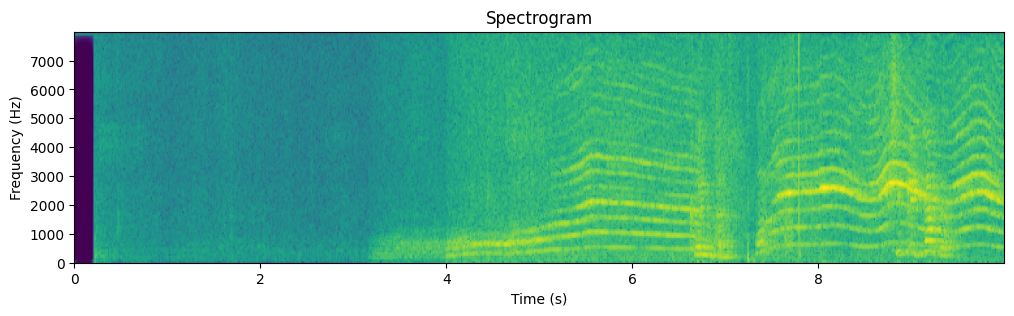

In [7]:
file_name = "0-0MLvQfung_0_10"      #A cat meowing and a human speaking

def validate_spectro(file_name):
    path = os.path.join(".\\CNN_data\\audio", (file_name + ".wav"))
    sample_rate = 16000
    audio = resample_audio(path, sample_rate)
    spectrogram = compute_spectrogram(audio, sample_rate=sample_rate, window_type='hann', nperseg=256, noverlap=32)
    spectrogram = normalize_spectogram(spectrogram)
    time = np.arange(0, 10, 1 / sample_rate)
    frequency = np.fft.fftfreq(10*sample_rate, 1 / sample_rate)
    plt.figure(figsize=(12, 3))
    plt.imshow(spectrogram, aspect='auto', cmap='viridis', origin='lower', extent=[time.min(), time.max(), 0, frequency.max()])
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    path2 = os.path.join(".\\CNN_data\\audio", (file_name + ".wav"))
    play_wav(path2)         #playing audio
    
validate_spectro(file_name=file_name)

In [8]:
def save_spectrogram_to_file(spectrogram, filename):
    """Serialize and save a spectrogram to a file."""
    np.save(filename, spectrogram)

def load_spectrogram_from_file(filename):
    """Load a spectrogram from a file."""
    return np.load(filename)


Re-serialize all of the data as spectrograms. This will allow the CNN training process to be faster, as for each step, the program will not have to compute short-term fourier transforms or audio resampling.

In [9]:
def map_data_as_spectro(sample_rate, window_type, nperseg, noverlap):
    input_dir = ".\\CNN_data\\audio"
    output_dir = ".\\CNN_data\\spectrograms"

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if the output directory is empty
    if not os.listdir(output_dir):
        # Loop through the files in the input directory
        for filename in tqdm(os.listdir(input_dir), desc="Processing files"):
            file_path_in = os.path.join(input_dir, filename)
            
            # Replace .wav extension with .npy
            filename_base = os.path.splitext(filename)[0]
            file_path_out = os.path.join(output_dir, f"{filename_base}.npy")

            # Read and resample the audio
            audio = resample_audio(file_path_in, sample_rate)

            try:
                # Compute and normalize the spectrogram
                spectrogram = compute_spectrogram(audio, sample_rate, window_type=window_type, nperseg=nperseg, noverlap=noverlap)
                spectrogram = normalize_spectogram(spectrogram)
            except ValueError as e:
                print(f"Error processing file '{filename}': {e}")
                continue

            # Save the spectrogram as a .npy file
            save_spectrogram_to_file(spectrogram, file_path_out)
    else:
        print(f"Output directory '{output_dir}' is not empty. Files not processed.")



The below code sets the hyperparams including the resample rate, nperseg, noverlap, and the window type. The function call writes the spectrograms as .npy files to the directory .\\CNN_data\\spectrograms

In [10]:
resample_rate = 16000
num_per_seg = 256
num_overlap = 32
window_type = 'hann'

map_data_as_spectro(resample_rate, window_type=window_type, nperseg=num_per_seg, noverlap=num_overlap)

Processing files: 100%|██████████| 3015/3015 [02:14<00:00, 22.44it/s]


Loading the labels from the tsv file containing labels

In [11]:
# Load labels from TSV file
labels_path = ".\\CNN_data\\weak_labels.tsv"
labels_df = pd.read_csv(labels_path, delimiter='\t')

file_column = 'filename'
label_column = 'event_label'

In [12]:
data_dir = ".\\CNN_data\\spectrograms"
file_paths = [os.path.join(data_dir, file.replace('.wav', '.npy')) for file in labels_df[file_column]]

2a)/b) The below cells represent the process of creating a dataset and splitting it into training, validation, and test sets.

In [13]:
def create_labels(label_str):
    # ORDER: 
    # [0] ALARM_BELL_RINGING 
    # [1] BLENDER
    # [2] CAT 
    # [3] DOG 
    # [4] DISHES
    # [5] ELECTRIC_SHAVER_TOOTHBRUSH 
    # [6] FRYING 
    # [7] RUNNING_WATER 
    # [8] SPEECH
    # [9] VACUUM_CLEANER
    label_mapping = {
        'alarm_bell_ringing': 0,
        'blender': 1,
        'cat': 2,
        'dog': 3,
        'dishes': 4,
        'electric_shaver_toothbrush': 5,
        'frying': 6,
        'running_water': 7,
        'speech': 8,
        'vacuum_cleaner': 9
    }

    # Initialize a vector of length 10 with zeros
    label_vector = np.zeros(10)

    # Split the label_str into individual labels
    
    labels = label_str.split(',')
    

    # Map each label to its corresponding index in the vector
    for label in labels:
        label = label.strip().lower()  # Remove leading/trailing whitespaces and convert to lowercase
        if label in label_mapping:
            label_index = label_mapping[label]
            label_vector[label_index] = 1

    return label_vector.reshape(10)
    

In [14]:
labels = [create_labels(x) for x in labels_df[label_column]]

Creating a dataframe

In [15]:
data = pd.DataFrame({file_column: file_paths, label_column: labels})

In [16]:
def load_data_from_file(filename_tensor):
    # Use tf.py_function to call the load_data_from_file function
    return tf.py_function(func=lambda filename: np.load(filename.numpy().decode('utf-8')), inp=[filename_tensor], Tout=tf.float32)

def load_and_preprocess(file_path, label):
    # Load and preprocess your spectrogram images (adjust as needed)
    spectrogram = load_data_from_file(file_path)
    return spectrogram, label

def add_channel_dimension(x, y):
    x = tf.expand_dims(x, axis=-1)
    return x, y



Setting a random seed which should allow for reproduceablility of data generation. Also, the below data splits the data into training, validation, and testing data:  
Training: 65.6%  
Validation: 16.4 %  
Test: 18 %  

(Note this split was later changed to ~70%, 10%, 15%)  
The hyperparameters are set here  

In [17]:
seed = 30978
model_name = "modeltemp"

np.random.seed(seed)
seed_1 = seed               
tf.random.set_seed(seed_1)  #currently the seed affects training/val/test data split as well as weights, I do not necessarily want this dependency
kernel_size = 6
max_pool_size = 25
num_conv_filters = 32
num_dense_layers = 4
dense_layer_size = 64
num_epochs = 8

train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=seed)

Creating the tensorflow datasets, and pre-shuffling them to remove structural biases

In [18]:
# Create TensorFlow datasets
batch_size = 16
labels_array_train = np.asarray(train_data[label_column].tolist(), dtype=np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[file_column], labels_array_train))
train_dataset = train_dataset.map(load_and_preprocess)
train_dataset = train_dataset.map(add_channel_dimension)
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [19]:
labels_array_val = np.asarray(val_data[label_column].tolist(), dtype=np.float32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data[file_column], labels_array_val))
val_dataset = val_dataset.map(load_and_preprocess)
val_dataset = val_dataset.map(add_channel_dimension)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [20]:
labels_array_test = np.asarray(test_data[label_column].tolist(), dtype=np.float32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data[file_column], labels_array_test))
test_dataset = test_dataset.map(load_and_preprocess)
test_dataset = test_dataset.map(add_channel_dimension)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

This is the grader cell. The purpose of this cell is to demonstrate a model's functionality without the requirement of training.

NOTE THAT:  
This model will likely run at a much better accuracy than reported in its model.csv  
This is due to the fact that the test dataset which has been generated was statistically more likely to be part of this (or any given model's) TRAINING set  
Thus the data on which this model is being evaluated HAS been seen before, so it is sort of an "unfair evaluation"  

In [41]:
##TO GRADE##

#Set grader_model to evaluate:
#options:
#model1
#model2.3
#model3.3
#model4.13
#model5.1


from tensorflow.keras.models import load_model
grader_model = 'model5.1'
if(GRADER_MODE):
    
    path = os.path.join(".\\Models\\pretrained", (grader_model+ ".h5"))
    print(path)
    
    #loading model:
    grader_model = load_model(path)
    grader_metrics = grader_model.evaluate(test_dataset)
    
    pass

.\Models\pretrained\model5.1.h5
29/29 [==============================] - 1s 25ms/step - loss: 0.2813 - binary_accuracy: 0.8799 - precision: 0.7899


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [23]:
#getting height & width from an arbitrary spectrogram, all spectrograms should be the SAME SIZE
file_name = "Y0BgI0XxW0kE_340.000_350.000"
path = os.path.join(".\\CNN_data\\spectrograms", (file_name + ".npy"))
spectrogram_1 = load_spectrogram_from_file(path)
height, width = spectrogram_1.shape


2 c) The below cell defines the model architecture. The initial model architecture is as shown below, for the "model1" series.

| Layer (type) | Output Shape | Param # |
|-----------|-----------|-----------|
| conv2d | (None, 127, 712, 32) | 320 |
| max_pooling2d | (None, 63, 356, 32) | 0 |
| flatten | (None, 717696) | 0 |
| dense (Dense) | (None, 64) | 45932608 |
| dense | (None, 10) | 650 |

The architecture was chosen with the following in mind:    
Layer 1: a 2D convolutional layer. This is required to make the network "convolutional"  
Layer 2: a "max pooling" layer This layer is extremely important, as it has been shown to help decrease the dependency on "locality" of information [2]. For instance, a bird in the top right of a picture is different than a bird in the bottom left, although both should be identified as a bird. Max pooling decouples "top right" and "bottom left" from "bird"  
Layer 3: Flatten: used to change the dimension of the output from 2-D to 1-D.   
Layer 4: Dense:  This is a classical, fully connected layer. This is present to increase the capacity of the NN  
Layer 5: Dense: this changes the output dimension to the required 10-D binary vector for classification  


[2] J. Nagi et al., "Max-pooling convolutional neural networks for vision-based hand gesture recognition," 2011 IEEE International Conference on Signal and Image Processing Applications (ICSIPA), Kuala Lumpur, Malaysia, 2011, pp. 342-347, doi: 10.1109/ICSIPA.2011.6144164.

In [24]:
# Defining model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(num_conv_filters, (kernel_size, kernel_size), activation='relu', input_shape=(height, width, 1)),
    tf.keras.layers.MaxPooling2D((max_pool_size, max_pool_size)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_layer_size),
    tf.keras.layers.Dense(dense_layer_size),
    tf.keras.layers.Dense(dense_layer_size),
    tf.keras.layers.Dense(dense_layer_size, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs
])


3. a)/b) The below code compiles the model. Note the optimizer, loss function, and additional metrics. 

The optimizer is 'Adam,' which is a stochastic-gradient descent optimizer. This will help to find the absolute minimum of the loss function. Note that due to the high non-linearity of the problem, 'Adam' is not guaranteed to find the absolute minimum.

The loss function, 'Binary Cross Entropy' is often used as a loss function for binary classification tasks. For a dataset with 10 possible binary classifications, this is given by: 

L = - (1/N) * Σ (yᵢ * log(ŷᵢ) + (1 - yᵢ) * log(1 - ŷᵢ))

The metrics generated by this model will be the loss function (described above), as well as binary accuracy (a measure of how accurate the classification was), and precision, which the percentage of guesses that were correct.

In [25]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision()])


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 709, 32)      1184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 28, 32)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                        

3. c)/d) Training/Validating the model:

In [27]:
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset, batch_size = 16)

Epoch 1/8
137/137 [==============================] - 20s 37ms/step - loss: 0.4189 - binary_accuracy: 0.8507 - precision: 0.5347 - val_loss: 0.3914 - val_binary_accuracy: 0.8590 - val_precision: 0.5540
Epoch 2/8
137/137 [==============================] - 6s 22ms/step - loss: 0.3620 - binary_accuracy: 0.8587 - precision: 0.6527 - val_loss: 0.3490 - val_binary_accuracy: 0.8642 - val_precision: 0.6036
Epoch 3/8
137/137 [==============================] - 6s 21ms/step - loss: 0.3358 - binary_accuracy: 0.8646 - precision: 0.6997 - val_loss: 0.3734 - val_binary_accuracy: 0.8605 - val_precision: 0.6522
Epoch 4/8
137/137 [==============================] - 6s 22ms/step - loss: 0.3202 - binary_accuracy: 0.8701 - precision: 0.7453 - val_loss: 0.3057 - val_binary_accuracy: 0.8753 - val_precision: 0.7437
Epoch 5/8
137/137 [==============================] - 6s 21ms/step - loss: 0.3018 - binary_accuracy: 0.8734 - precision: 0.7428 - val_loss: 0.3226 - val_binary_accuracy: 0.8678 - val_precision: 0.6161

4. a)/b) Model testing and visualization:

In [28]:
final_metrics = model.evaluate(test_dataset)
create_directory(os.path.join(".\\Models", model_name))

29/29 [==============================] - 1s 27ms/step - loss: 0.3052 - binary_accuracy: 0.8711 - precision: 0.7112
Directory '.\Models\modeltemp' already exists.


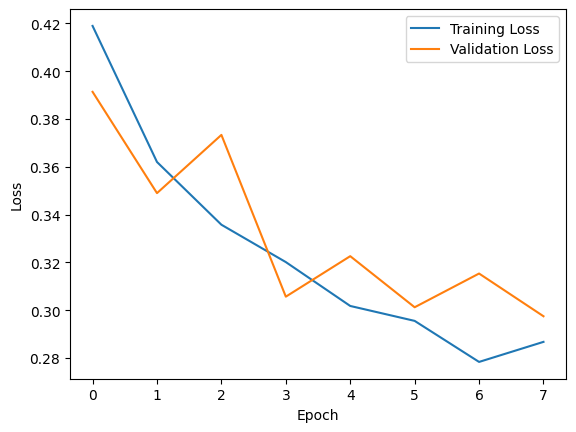

In [29]:
# Plot loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f".\\Models\\{model_name}\\loss.png")
plt.show()


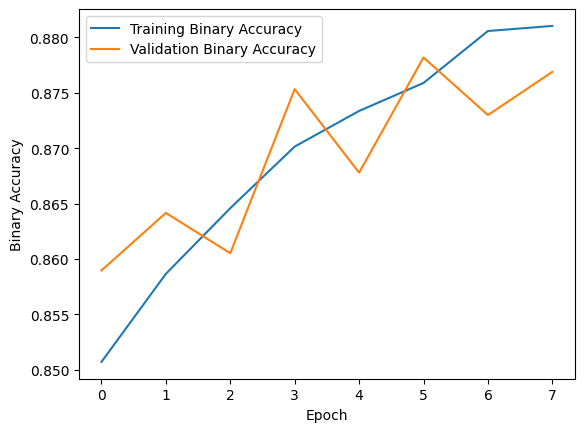

In [30]:
plt.plot(history.history['binary_accuracy'], label='Training Binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.savefig(f".\\Models\\{model_name}\\accuracy.png")
plt.show()

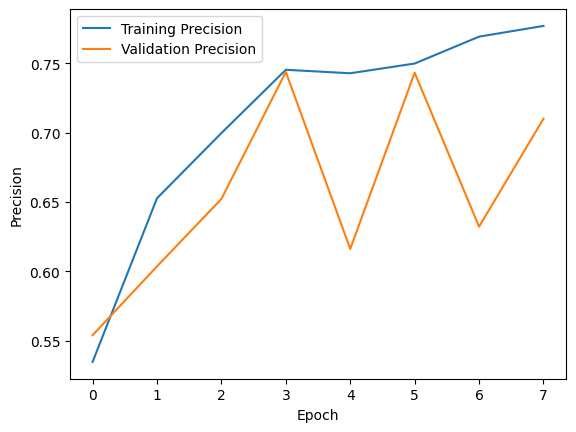

In [31]:

plt.plot(history.history['precision'], label='Training Precision')    #Note when re-running cell by cell, the precision_X increments by 1
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.savefig(f".\\Models\\{model_name}\\Precision.png")
plt.show()


In [32]:
test_loss = final_metrics[0]
test_binary_accuracy = final_metrics[1]
test_precision = final_metrics[2]

generalization_error = {
    'Test Loss': test_loss,
    'Test Binary Accuracy': test_binary_accuracy,
    'Test Precision': test_precision
}

print("Generalization Error:")
for metric, value in generalization_error.items():
    print(f"{metric}: {value}")

Generalization Error:
Test Loss: 0.30521848797798157
Test Binary Accuracy: 0.8710816502571106
Test Precision: 0.7112069129943848


In [33]:
model.save(os.path.join(".\\Models", model_name, (model_name + ".h5")))

hyperparams = [resample_rate, num_per_seg, num_overlap, window_type, kernel_size, max_pool_size, num_conv_filters, num_dense_layers, dense_layer_size, num_epochs, seed_1]

import csv

def write_hyperparameters_to_csv(file_path, hyper_params, generalization_error):
    """
    Write hyperparameters and their corresponding values to a CSV file.

    Parameters:
    - file_path (str): The path to the CSV file.
    - hyper_params (list): List of hyperparameter values.
    """
    # Open the CSV file in write mode
    with open(file_path, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        # Write data rows
        writer.writerow(['Resample Rate', hyper_params[0]])
        writer.writerow(['Num Per Seg', hyper_params[1]])
        writer.writerow(['Num Overlap', hyper_params[2]])
        writer.writerow(['Window Type', hyper_params[3]])
        writer.writerow(['Kernel Size', hyper_params[4]])
        writer.writerow(['Max Pool Size', hyper_params[5]])
        writer.writerow(['Num Conv Filters', hyper_params[6]])
        writer.writerow(['Num Dense Layers', hyper_params[7]])
        writer.writerow(['Dense Layer Size', hyper_params[8]])
        writer.writerow(['Num Epochs', hyper_params[9]])
        writer.writerow(['Seed', hyper_params[10]])
        writer.writerow(["Generalization Error:"])
        for metric, value in generalization_error.items():
            writer.writerow([f"{metric}: {value}"])
                
write_hyperparameters_to_csv(os.path.join(".\\Models", model_name, (model_name + ".csv")), hyper_params=hyperparams, generalization_error=generalization_error)

In [34]:
#Cell present to indicate when training is done!
def play_ping_sound():
    # Initialize Pygame mixer
    pygame.mixer.init()

    # Load the ping sound file (replace 'ping_sound.wav' with your actual sound file)
    sound_file = 'ping_sound.wav'
    pygame.mixer.music.load(sound_file)

    # Play the ping sound
    pygame.mixer.music.play()

    # Wait for the sound to finish playing
    while pygame.mixer.music.get_busy():
        time.sleep(1)
        
play_ping_sound()

4. c): 
### Hyperparameter tuning

Models 1-4 represent tuning of the respective hyperparameters shown below:  

Model 1: Epochs
Model 2: Capacity
Model 3: Convolutional Kernel Size
Model 4: Max Pooling Kernel Size

and the further models (5,6,7, 8) examined the effect of different window types.

My process for tuning was to fix all of the parameters except the one of interest, and then increment that parameter from a base value (e.g., for epochs, start at 4, then increase). I would fix the hyperparameter when I found that it was not resulting in better results from the test data. The sub-models represent the incrementation process, so model1 starts with the base structure at 4 epochs while model1.10 is the same, trained over 14 epochs. The hyperparameters for each model are stored in human-readable form under model/model.csv.

Note that this process is not guaranteed to result in optimal parameters, but it is a good attempt at manual tuning.

5. a): Models 5, 6, 7, and 8 examine the effect of different window types on the accuracy of the neural network.

All of these window types are provided by the scipy library. The hann window was the default window type for all previous models up to and including 5. The average test loss, accuracy, and precision are given in the table (each cell represents the average over the four models, i.e. row 5 shows the average test loss, binary accuracy, and precision for model5, model5.1, model5.2, and model5.3).
  
| Model Number | Window Type | Test Loss | Binary Accuracy | Precision |
|-----------|-----------|-----------|-----------|-----------|
| 5 | Hann | 0.317 | 0.8723 | 0.7226 |
| 6 | Hamming | 0.3096|0.8733 | 0.6827 |
| 7 | Boxcar | 0.3089 | 0.8729 | 0.6823 |
| 8 | Triang | 0.3069 | 0.8737 |0.7145 |

In conclusion, there is little difference between the different selected window types and how they affect the CNN. With only 4 models of each type to draw an average from, the relative differences in the three metrics is not likely to be significant. This is probably due to the fact that the appearance of the spectrogram, in terms of rough visual patterns, is changed little by the window type. A much larger impact is had by the structure of the neural network itself.


# Relevant Results and Discussion

![Local Image](./Results/test_loss_vs_epochs_1.png)  <br></br>

The above image graphs the test loss vs the number of epochs for model 1. Note that the loss has a rather large variation over epochs, and there does not seem to be a clear relationship. Therefore, fixing the number of epochs was difficult.

The precision and accuracy of model 1 showed no clear trends over epochs as well (graphs in results folder). I postulate several reasons for this:
- The initial model is poorly tuned in terms of hyperparameters. Therefore the loss function is likely highly nonlinear, and the 'Adam' is probably not effective at finding optimal weights for this model
- The dataset is sparse. The dataset has approximately 3000 items in it, and there are 10 categories. This means the amount of audio samples per category is on the order of 100s of samples, including overlap (e.g. files which have more than one label)
- Due to the sparse dataset and high number of labels, the training/validation/test split is poor. Since the test dataset has approximately 15% of the data, and this corresponds to about ~450 samples, it is possible to get a high concentration of a particular label in the test dataset, which would mean this label is almost entirely absent from the training set

To mitigate these factors, I would have to train and run each model from series 1 multiple times, and plot their average. Due to training times in this project, I will determine the optimal number of epochs as follows:

We can examine this graph from model1.10 <br></br> ![Local Image](./Models/model1.10/loss.png) <br></br> Which shows the training/validation loss over epochs. From this graph, it seems like the optimal number of epochs is approximately between 6-8. Although altering the model further will change what number of epochs is optimal, I will fixed this hyperparameter at 8. Note that this decision was later validated by model9. model9 is based on the model5 architecture, so it is fairly well optimized. It is clear from the below graph that the optimal number of epochs hover somewhere around 10 to avoid overfitting.

![Local Image](./Models/model9/loss.png)

Note that many of the loss, precision, and accuracy figures shown in the models directory have a large degree of variance. In general, it may be difficult to pick out a trend from the figures. This is due to the same reasons that it was difficult to determine the optimal number of epochs form model1 alone. The above figure, as it is run over 50 epochs, provides a better visualization of the trends of loss vs. epoch, and this agrees with theory. Below are shown binary accuracy and precision for model 9, and these figures provide a good visualization for their respective quantities that agrees with theory. Once again, this shows that the optimal number of epochs to avoid overfitting is around 8. 

#### Binary Accuracy
![Local Image](./Models/model9/accuracy.png)

### Precision
![Local Image](./Models/model9/Precision.png)

# Conclusion

The best results were acheived by model 5.1. It had a test cross binary cross entropy loss of 0.3064, a binary accuracy of 0.881, and a precision of 77.09%. In comparison with model 1:

| Metric | Model 1 | Model 5.1 |
|-----------|-----------|-----------|
| Loss | 0.4972 | 0.3064 | 
| Binary Accuracy | 0.8632 | 0.881|
| Precision | 0.5882 | 0.7709 | 




With further hyperparameter tuning and a larger dataset, it would be feasible to achieve classification rates well over 90 %. Additionally, the methodology used for hyperparameter optimization in this context was manual and tedious. With an automatic method, better hyperparameters would have been found. Additionally, it would have been possible to change the architecture of the CNN, for example including multiple convolutional or max pooling layers, experimenting with other layer types, or even activation funcitons. As the space of hyperparameters is exceedingly deep, I limited my search due to time constraints and the scope of this project.


This is a good method for classifying audio. The largest difference in model accuracy was made by the increase in capacity by adding layers, and increasing the max pooling size. The max pooling layer was extremely important, as it helped decouple the dependency on locality the neural network had when identifying similar features. Max pooling kernel size, when tuned as a hyperparameter, showed the largest improvement in evaluation metrics compared to other hyperparameters.

Of the four window functions examined ('Hann', 'Hamming', 'Boxcar', and 'Triang'), none of them showed significant improvement to model accuracy or precision. I can therefore conclude that the window function choice does not play a large role in this context. I postulate that this is due to the fact that the window function does not significantly change the visual features of a spectrogram. 